# Music genre classifier
## Neural networks as classifiers
This notebook should be see as the third step in a series of notebooks aimed to build an ML audio classifier.

We continue our journey of music classification by trainging more complex models, such as CNNs and RNNs.
After this, we will see how our results compare against a pretrained model. 
If you missed our previous steps, you can find them here:

- [preprocessing](https://github.com/pmhalvor/public-data/blob/master/notebooks/music-genre/preprocess.py)
- [traditional classifiers](https://github.com/pmhalvor/public-data/blob/master/notebooks/music-genre/classifiers.py) (note: currently only on branch [add/classifiers](https://github.com/pmhalvor/public-data/blob/add/classifiers/notebooks/music-genre/classifiers.ipynb))


## Goal
Train neural net classifiers to predict the genre of a song.

## Dataset
The dataset contains 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks were all 22050Hz Mono 16-bit audio files in .wav format.
In [preprocess.py](preprocess.py), we convert the .wav fiels to MFCC features, and store them as PyTorch tensors (`mfcc.pt`). Labels and file paths are stored as numpy-arrays. 

## Source
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/ (accessed 2023-10-20)

In [2]:
from functools import partial
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from skorch import NeuralNetClassifier
from tqdm import tqdm

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data

In [3]:
mfcc_tensor = torch.load("mfcc.pt")
covariance_tensor =  torch.load("covariance.pt")
file_paths = np.load("file_paths.npy")
labels = np.load("labels.npy")

In [4]:
mfcc_tensor.shape

torch.Size([999, 2986, 13])

In [5]:
labels.shape

(999,)

In [6]:
# for plotting
file_paths.shape

(999,)

In [7]:
labels_to_idx = {label: idx for idx, label in enumerate(np.unique(labels))}
idx_to_labels = {idx: label for idx, label in enumerate(np.unique(labels))}
labels_to_idx

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

# Build simple NN classifiers

We limit the scope of this notebook to the most basic NN architectures, namely MLPs, CNNs and RNNs.

## MLP
A **multi-layer perceptron** (MLP) is a class of feedforward neural network (FNN) composed of multiple layers, each with their own activation function. 
Multilayer perceptrons can be considered the most "vanilla" neural networks, as they resemble the simplest possible neural network architecture: a linear classifier.

### Architecture
The MLP consists of an input layer, a hidden layer and an output layer.
The input layer is the same size as the input data, and the output layer is the same size as the number of classes.
The hidden layer can be of any size, but is usually smaller than the input and output layers.
The hidden layer is where the "magic" happens, as it is where the network learns to classify the data.

### Training
The MLP is trained using backpropagation, which is an algorithm for computing the gradient of the loss function with respect to the weights of the network.
The loss function is usually the cross-entropy loss, which is a measure of the difference between the predicted and the actual class.
The weights are updated using gradient descent, which is an algorithm for minimizing the loss function.

### Activation functions
The activation function is a non-linear function that is applied to the output of each neuron in the network.
The activation function is what makes the MLP a universal function approximator, as it allows the network to learn non-linear functions.
The activation function is usually applied to the output of each neuron in the hidden layer, but can also be applied to the output layer.
The activation function is usually the sigmoid function, but can also be the hyperbolic tangent function or the rectified linear unit (ReLU) function.

## CNN
A **convolutional neural network** (CNN) is a class of feedforward neural network (FNN) composed of multiple layers, each with their own activation function.
CNNs are a type of neural network that are particularly well suited for image classification, as they are able to learn spatial features.
This means, they may perform better on spectrogram transformations of our data, rather than MFCC simplifications.

### Architecture
The CNN consists of an input layer, a convolutional layer, a pooling layer, a hidden layer and an output layer.
The input layer is the same size as the input data, and the output layer is the same size as the number of classes.
The convolutional layer is where the "magic" happens, as it is where the network learns to classify the data.
The pooling layer is used to reduce the dimensionality of the data, and is usually placed after the convolutional layer.
The hidden layer can be of any size, but is usually smaller than the input and output layers.

### Training
The CNN is trained using backpropagation, which is an algorithm for computing the gradient of the loss function with respect to the weights of the network.
The loss function is usually the cross-entropy loss, which is a measure of the difference between the predicted and the actual class.
The weights are updated using gradient descent, which is an algorithm for minimizing the loss function.

### Activation functions
The activation function is a non-linear function that is applied to the output of each neuron in the network.
The activation function is what makes the CNN a universal function approximator, as it allows the network to learn non-linear functions.
The activation function is usually applied to the output of each neuron in the hidden layer, but can also be applied to the output layer.
The activation function is usually the sigmoid function, but can also be the hyperbolic tangent function or the rectified linear unit (ReLU) function.

## RNN
A **recurrent neural network** (RNN) is a class of feedforward neural network (FNN) composed of multiple layers, each with their own activation function.
RNNs are a type of neural network that are particularly well suited for time series classification, as they are able to learn temporal features.
This means, they may perform better on raw audio data, rather than spectrogram transformations.

### Architecture
The RNN consists of an input layer, a recurrent layer, a hidden layer and an output layer.
The input layer is the same size as the input data, and the output layer is the same size as the number of classes.
The recurrent layer is where the "magic" happens, as it is where the network learns to classify the data.
The hidden layer can be of any size, but is usually smaller than the input and output layers.

### Training
The RNN is trained using backpropagation, which is an algorithm for computing the gradient of the loss function with respect to the weights of the network.
The loss function is usually the cross-entropy loss, which is a measure of the difference between the predicted and the actual class.
The weights are updated using gradient descent, which is an algorithm for minimizing the loss function.

### Activation functions
The activation function is a non-linear function that is applied to the output of each neuron in the network.
The activation function is what makes the RNN a universal function approximator, as it allows the network to learn non-linear functions.
The activation function is usually applied to the output of each neuron in the hidden layer, but can also be applied to the output layer.
The activation function is usually the sigmoid function, but can also be the hyperbolic tangent function or the rectified linear unit (ReLU) function.




In [8]:
features = 13
measurements = 2986
input_size = measurements * features  # Number of MFCC coefficients
hidden_size = 128  # Number of neurons in the hidden layer
num_classes = 10  # Number of music genres
criterion = nn.CrossEntropyLoss()

# Hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001
rnn_layers = 2

In [9]:
class FFN(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_classes=num_classes, num_layers=2):
        super(FFN, self).__init__()
        self.fc_first = nn.Linear(input_size, hidden_size)
        self.fc_last = nn.Linear(hidden_size, num_classes)
        self.num_layers = num_layers

        if num_layers > 1:
            self.fc_hidden = nn.ModuleList()
            for i in range(num_layers - 1):
                self.fc_hidden.append(nn.Linear(hidden_size, hidden_size))
    
    def forward(self, x):
        x = F.relu(self.fc_first(x))
        
        # hidden layers
        if self.num_layers > 1:
            for i in range(self.num_layers - 1):
                x = F.relu(self.fc_hidden[i](x))

        # output layer
        x = self.fc_last(x)
        
        return x
    

In [10]:
class CNN(nn.Module):
    def __init__(self, num_channels=13, num_classes=10, out_channels=32, measurements=2986, verbose=False):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(out_channels * measurements * 3, num_classes)  # Adjust the input size based on your data

        self.measurements = measurements
        
        self.verbose = verbose
    
    def forward(self, x):
        print("input", x.shape) if self.verbose else None
        x = self.conv1(x)
        print("conv1", x.shape) if self.verbose else None
        x = self.relu(x)
        print("relu", x.shape) if self.verbose else None
        x = self.maxpool(x)
        print("maxpool", x.shape) if self.verbose else None
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        print("fc", x.shape) if self.verbose else None
        print("-"*10) if self.verbose else None
        return x


In [11]:
class RNN(nn.Module):
    def __init__(self, input_size=13, hidden_size=15, num_layers=2, num_classes=10, verbose=False):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.verbose = verbose
    
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward pass through the GRU layer
        gru_out, _ = self.gru(x)

        # Use the final hidden state as the input for the fully connected layer
        output = self.fc(gru_out[:, -1, :])

        return output




# Train test split

In [12]:
# Reshape the data into a 2D array (num_samples, num_features)
num_samples, num_frames, num_mfcc = mfcc_tensor.shape
mfcc_tensor_2d = np.reshape(mfcc_tensor, (num_samples, num_frames * num_mfcc))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc_tensor_2d, labels, test_size=0.2, random_state=42)

# Get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [13]:
uniques, counts = np.unique(y_train, return_counts=True)
dict(zip(uniques, counts))

{'blues': 73,
 'classical': 61,
 'country': 68,
 'disco': 71,
 'hiphop': 73,
 'jazz': 71,
 'metal': 80,
 'pop': 72,
 'reggae': 77,
 'rock': 73}

# Train methods

In [14]:
X_train.reshape(*[-1, 1, measurements, features]).shape

torch.Size([719, 1, 2986, 13])

In [15]:
def train_batch(batch, model, criterion, optimizer):
    # Get the batch of data
    batch_X, batch_y = batch
    # convert strings to ids
    batch_y = np.array([labels_to_idx[x] for x in batch_y])
    batch_X = batch_X.float()
    
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(batch_X)
    loss = criterion(outputs, torch.tensor(batch_y))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()  


def eval_batch(X_test, y_test, model, criterion):
     # Evaluate
    model.eval()
    with torch.no_grad():
        X_test = X_test.float()
        y_test = torch.tensor([labels_to_idx[x] for x in y_test])
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    
    return loss.item()


def train_epoch(X_train, y_train, model, criterion, optimizer, batch_size=100):
    # Shuffle the training data
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    
    # Create batches
    num_batches = len(X_train) // batch_size
    batches = [(X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]) for i in range(num_batches)]
    
    # Train each batch
    losses = []
    for batch in batches:
        loss = train_batch(batch, model, criterion, optimizer)
        losses.append(loss)
    
    return losses


def train_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, reshape=None, num_epochs=10, batch_size=100, verbose=False, n=10):
    train_losses = []
    eval_losses = []
    average_loss = []

    if reshape:
        X_train = X_train.reshape(*reshape)
        X_test = X_test.reshape(*reshape)
    
    for epoch in tqdm(range(num_epochs)):
        
        # Train
        model.train()
        losses = train_epoch(X_train, y_train, model, criterion, optimizer, batch_size=batch_size)
        train_losses.extend(losses)
        average_loss.append(np.mean(losses))
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            eval_loss = eval_batch(X_test, y_test, model, criterion)
            eval_losses.append(eval_loss)
        
        if verbose or epoch % n == 0:
            print(
                'Epoch: {}'.format(epoch),
                'Train loss: {:.4f}'.format(losses[-1]),
                'Test  loss: {:.4f}'.format(eval_losses[-1])
            )
        

    return train_losses, eval_losses, average_loss


X_train.numpy().shape


(719, 38818)

In [16]:
def plot_losses(train_losses, val_losses, model=""):
    """Plot using Plotly Express"""
    import plotly.express as px
    import pandas as pd
    pd.options.plotting.backend = "plotly"
    
    df = pd.DataFrame({
        'epoch': np.arange(len(train_losses)),
        'train_loss': train_losses,
        'val_loss': val_losses
    })
    
    fig = px.line(df, x='epoch', y=['train_loss', 'val_loss'], title=f'Losses {model}')
    fig.show()

# Training

## Feed Forward 

In [17]:
input_size = 38818  # fixed
num_classes = 10    # fixed

hidden_size = 128*7 # tunable
num_layers = 2      # tunable
lr=0.00001          # tunable

In [18]:
ffn_model = FFN(input_size, hidden_size, num_classes, num_layers)
optimizer_ffn = optim.Adam(ffn_model.parameters(), lr=lr, weight_decay=1e-7)  # double check optimizer set-up

ffn_train_losses, ffn_val_losses, ffn_avg_losses = train_model(
    X_train, y_train, X_test, y_test, ffn_model, criterion, optimizer_ffn, 
    num_epochs=10, batch_size=batch_size, verbose=False
)

plot_losses(ffn_avg_losses, ffn_val_losses, "FFN")

 10%|█         | 1/10 [00:00<00:05,  1.62it/s]

Epoch: 0 Train loss: 3.5791 Test  loss: 3.2244


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


In [19]:
ffn_model = FFN(input_size, 128*5, num_classes)
optimizer_ffn = optim.Adam(ffn_model.parameters(), lr=0.00001)  # double check optimizer set-up

ffn_train_losses, ffn_val_losses, ffn_avg_losses = train_model(
    X_train, y_train, X_test, y_test, ffn_model, criterion, optimizer_ffn, 
    num_epochs=15, batch_size=batch_size, verbose=False
)

plot_losses(ffn_avg_losses, ffn_val_losses, "FFN")

  7%|▋         | 1/15 [00:00<00:04,  2.82it/s]

Epoch: 0 Train loss: 2.0811 Test  loss: 2.0411


 73%|███████▎  | 11/15 [00:03<00:01,  2.83it/s]

Epoch: 10 Train loss: 0.0495 Test  loss: 1.5536


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


## CNN

In [20]:
# Initialize the CNN model
num_channels = 1  # Since each feature is treated as a channel
num_classes = 10  # Number of output classes

In [21]:
# Initialize the CNN model, loss function, and optimizer
cnn_model = CNN(num_channels, num_classes, out_channels=32, measurements=2986)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0001)

cnn_train_losses, cnn_val_losses, cnn_avg_losses = train_model(
    X_train, y_train, X_test, y_test, cnn_model, criterion, optimizer_cnn, 
    reshape=[-1, 1, measurements, features],
    num_epochs=15, batch_size=batch_size, verbose=False
)

plot_losses(cnn_avg_losses, cnn_val_losses, "CNN")

  7%|▋         | 1/15 [00:03<00:53,  3.80s/it]

Epoch: 0 Train loss: 586.9229 Test  loss: 537.9610


 73%|███████▎  | 11/15 [00:41<00:14,  3.74s/it]

Epoch: 10 Train loss: 6.3264 Test  loss: 19.8348


100%|██████████| 15/15 [00:56<00:00,  3.75s/it]


## RNN

In [22]:
features = 13  # Number of features
hidden_size = 128  # Number of hidden units in the RNN layer
num_layers = 2  # Number of RNN layers
num_classes = 10  # Number of output classes (genres)
batch_size = 100  # Number of examples in a batch

In [23]:
# Initialize the RNN model, loss function, and optimizer
rnn_model = RNN(features, hidden_size, num_layers*2, num_classes, verbose=False)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=.01, weight_decay=1e-7)

rnn_train_losses, rnn_val_losses, rnn_avg_losses = train_model(
    X_train, y_train, X_test, y_test, rnn_model, criterion, optimizer_rnn, 
    reshape=[-1, measurements, features],
    num_epochs=10, batch_size=64, verbose=False
)

plot_losses(rnn_avg_losses, rnn_val_losses, "RNN")

 10%|█         | 1/10 [00:16<02:27, 16.40s/it]

Epoch: 0 Train loss: 1.8579 Test  loss: 1.7179


100%|██████████| 10/10 [02:43<00:00, 16.37s/it]


# Evaluate


In [76]:
def metrics(predictions, y_labels, verbose=False):
    """Calculate accuracy, F1 score, and confusion matrix"""
    accuracy = accuracy_score(y_labels, predictions)
    f1 = f1_score(y_labels, predictions, average='weighted', zero_division=0)
    confusion = confusion_matrix(y_labels, predictions, labels=list(labels_to_idx))
    report = classification_report(y_labels, predictions, zero_division=0)

    if verbose:
        print("Accuracy:", accuracy)
        print("F1 Score:", f1) 
        if verbose > 1:
            print("Classification Report:\n", report)
    return accuracy, f1, confusion, report

In [77]:
def plot_confusion_matrix(cm, classes=list((labels_to_idx)), name="", cmap=px.colors.sequential.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    fig = px.imshow(cm, x=classes, y=classes, color_continuous_scale=cmap)
    fig.update_layout(title="Confusion matrix "+name, xaxis_title="Predicted", yaxis_title="Actual")
    fig.show()


In [26]:
def evaluate(model, X_val=X_val, y_val=y_val, name="", reshape=None, plot=True, verbose=True):
    """Evaluate the model on the validation set"""
    model.eval()
    with torch.no_grad():
        X_val = X_val.reshape(*reshape).float() if reshape else X_val.float()
        # y_val = torch.tensor([labels_to_idx[x] for x in y_val])

        outputs = model(X_val)

        # ffn_preds = np.argmax(ffn_outputs, axis=1)
        _, predictions = torch.max(outputs.data, 1)
        predictions = np.array([idx_to_labels[pred.item()] for pred in predictions])
        accuracy, f1, confusion, report = metrics(predictions, y_val, verbose=verbose)

        print("(Prediction, Label): ", list(zip(predictions, y_val))) if verbose>1 else None

        plot_confusion_matrix(confusion, name=name) if plot else None
    
    return accuracy, f1, confusion, report

In [67]:
ffn_eval = evaluate(ffn_model, name="FFN", verbose=2)

Accuracy: 0.5625
F1 Score: 0.5542191876750701
Classification Report:
               precision    recall  f1-score   support

       blues       0.40      0.40      0.40         5
   classical       0.82      0.82      0.82        11
     country       0.50      0.20      0.29        10
       disco       0.29      0.40      0.33         5
      hiphop       0.44      0.57      0.50         7
        jazz       0.75      0.67      0.71         9
       metal       0.78      0.88      0.82         8
         pop       0.62      0.71      0.67         7
      reggae       0.56      0.62      0.59         8
        rock       0.30      0.30      0.30        10

    accuracy                           0.56        80
   macro avg       0.55      0.56      0.54        80
weighted avg       0.57      0.56      0.55        80

(Prediction, Label):  [('hiphop', 'hiphop'), ('metal', 'metal'), ('rock', 'blues'), ('rock', 'jazz'), ('classical', 'country'), ('classical', 'classical'), ('country', 'cl

In [68]:
# # # 7 layers *5 hidden size 0 weigh decay
# # Accuracy: 0.625
# # F1 Score: 0.5968102918258138
# ffn_eval = evaluate(ffn_model, plot=True)


In [69]:
cnn_eval = evaluate(cnn_model, name="CNN", plot=True, reshape=[-1, 1, measurements, features])

Accuracy: 0.45
F1 Score: 0.4143696581196581


In [70]:
rnn_eval = evaluate(rnn_model, X_val=X_val, name="RNN", plot=True, reshape=[-1, measurements, features])

Accuracy: 0.575
F1 Score: 0.5649758932279714


# Hyperparameter tuning


In [31]:
def get_module_name(model):
    """Get the name of the model"""
    return model.__class__.__name__

In [73]:
def grid_search(
        classifier, params, cv=5, 
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
        reshape=None,
        return_full_metrics=False, verbose=False, plot=True, name=""
    ):
    # Create a GridSearchCV object with the specified parameter grid and classifier
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=cv, n_jobs=-1, scoring="f1_macro")  #scoring= f1 with average='weighted'?

    if reshape:
        X_train = X_train.reshape(*reshape)
        X_test = X_test.reshape(*reshape)

    # Perform grid search on your data
    label_idx_train = np.array([labels_to_idx[x] for x in y_train])
    grid_search.fit(X_train, label_idx_train)

    # Print the best parameters found by the grid search
    print("Best Parameters:", grid_search.best_params_)

    # Make predictions using the best estimator
    predictions = grid_search.predict(X_test)
    predictions = np.array([idx_to_labels[pred] for pred in predictions])
    print("(Prediction, Label): ", list(zip(predictions, y_test))) if verbose>1 else None

    accuracy, f1, cm, cr = metrics(predictions, y_test, verbose=verbose)
    
    # append classifier name and params for plotting
    grid_search.name = get_module_name(classifier)
    grid_search.params = params
    grid_search.f1 = f1
    grid_search.accuracy = accuracy
    grid_search.cm = cm
    grid_search.cr = cr

    if return_full_metrics:
        return accuracy, f1, cm, cr, grid_search
    
    plot_confusion_matrix(cm, name=name) if plot else None

    return grid_search


def plot_grid_seach(gs, score_col="mean_test_score", param_cols=None, verbose=0):
    """#d plot of grid search with params on x and y and score on z axis"""
    gs_df = pd.DataFrame(gs.cv_results_)

    # get score column
    if score_col is None:
        score_col = [x for x in gs_df.columns if "score" in x].pop()
        print("score_col", score_col) if verbose>1 else None

    # get param cols
    if param_cols is None:
        param_cols = [x for x in gs_df.columns if "param_" in x]
        print("param_cols", param_cols) if verbose >3 else None

    # get sizes
    x_size = len(gs_df[param_cols[0]].unique())
    y_size = len(gs_df[param_cols[1]].unique())

    # get x, y, z  # need smart way of finding df size..
    x = gs_df[param_cols[0]].values.reshape(x_size, y_size).T[0]
    y = gs_df[param_cols[1]].values.reshape(y_size, x_size)[0]
    z = gs_df[score_col].values.reshape(x_size, y_size).T

    fig = go.Figure(
        data=[go.Surface(
            x=x, y=y, z=z, 
            hovertemplate=f"{param_cols[0]}: {'%{x}'}<br>{param_cols[1]}: {'%{y}'}<br>{score_col}: {'%{z}'}<extra></extra>",
        )]
    )
    fig.update_layout(
        title=f"GridSearchCV Results for {gs.name} Classifier", 
        scene=dict(
            xaxis_title=param_cols[0], 
            yaxis_title=param_cols[1], 
            zaxis_title=score_col,
            # xaxis_type="log" if "x" in log else "linear",
            # yaxis_type="log" if "y" in log else "linear",
            # zaxis_type="log" if "z" in log else "linear",
        ),
        height=750,
    )

    if verbose > 2:
        print("x", x)
        print("y", y)
        print("z", z)

    return fig.show()



## Feed Forward

In [33]:
# Initialize the FFN model, loss function, and optimizer
ffn_net = NeuralNetClassifier(
    FFN, 
    module__input_size=input_size,  # 38818
    module__num_classes=num_classes,  # 10
    criterion=nn.CrossEntropyLoss, 
    optimizer=optim.Adam, 
    lr=0.00001, 
    max_epochs=10, 
    batch_size=100, 
    # device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=0
)

In [71]:
ffn_gs = grid_search(
    ffn_net,
    params={
        "module__hidden_size": [128*5, 128*6, 128*7, 128*8, 128*9],
        "module__num_layers": [1, 2, 3, 4, 5],
    },
    name="FFN",
    verbose=2,
)

# so far best params: {'module__hidden_size': 640, 'module__num_layers': 3, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 1e-05}
# Accuracy: 0.525
# F1 Score: 0.5222471631893988
# weird that we got all the way up to .60 earlier 
# though that one had 7 layers  


/opt/homebrew/Caskroom/miniconda/base/envs/music-genre/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Parameters: {'module__hidden_size': 896, 'module__num_layers': 5}
(Prediction, Label):  [('hiphop', 'reggae'), ('reggae', 'hiphop'), ('disco', 'disco'), ('blues', 'blues'), ('disco', 'hiphop'), ('classical', 'classical'), ('rock', 'country'), ('classical', 'classical'), ('reggae', 'reggae'), ('disco', 'rock'), ('blues', 'jazz'), ('blues', 'rock'), ('country', 'country'), ('disco', 'rock'), ('hiphop', 'hiphop'), ('pop', 'pop'), ('country', 'country'), ('blues', 'reggae'), ('jazz', 'blues'), ('rock', 'disco'), ('classical', 'classical'), ('metal', 'blues'), ('country', 'country'), ('jazz', 'country'), ('classical', 'jazz'), ('pop', 'pop'), ('metal', 'metal'), ('hiphop', 'disco'), ('rock', 'country'), ('blues', 'blues'), ('classical', 'classical'), ('rock', 'blues'), ('blues', 'rock'), ('classical', 'classical'), ('rock', 'rock'), ('blues', 'rock'), ('metal', 'metal'), ('metal', 'metal'), ('disco', 'rock'), ('classical', 'classical'), ('disco', 'hiphop'), ('metal', 'blues'), ('jazz',

In [72]:
plot_grid_seach(ffn_gs)


## CNN
This one might be difficult to hyperparameter to tune. 

In [40]:
# Initialize the FFN model, loss function, and optimizer
cnn_net = NeuralNetClassifier(
    CNN, 
    module__num_channels=1,  # Since each feature is treated as a channel
    criterion=nn.CrossEntropyLoss, 
    optimizer=optim.Adam, 
    lr=0.00001, 
    max_epochs=10, 
    batch_size=100, 
    # device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=0
)

In [41]:
cnn_gs = grid_search(
    cnn_net,
    params={
        "optimizer__lr": [0.0001, 0.00001],
        "optimizer": [optim.Adam, optim.SGD],
    },
    name="CNN",
    reshape=[-1, 1, measurements, features],
    verbose=2,
)

/opt/homebrew/Caskroom/miniconda/base/envs/music-genre/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Parameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.0001}
(Prediction, Label):  [('hiphop', 'reggae'), ('metal', 'hiphop'), ('disco', 'disco'), ('blues', 'blues'), ('disco', 'hiphop'), ('classical', 'classical'), ('blues', 'country'), ('blues', 'classical'), ('blues', 'reggae'), ('disco', 'rock'), ('blues', 'jazz'), ('blues', 'rock'), ('rock', 'country'), ('disco', 'rock'), ('hiphop', 'hiphop'), ('pop', 'pop'), ('country', 'country'), ('blues', 'reggae'), ('blues', 'blues'), ('rock', 'disco'), ('jazz', 'classical'), ('disco', 'blues'), ('blues', 'country'), ('blues', 'country'), ('classical', 'jazz'), ('disco', 'pop'), ('metal', 'metal'), ('pop', 'disco'), ('disco', 'country'), ('blues', 'blues'), ('classical', 'classical'), ('blues', 'blues'), ('blues', 'rock'), ('jazz', 'classical'), ('blues', 'rock'), ('country', 'rock'), ('metal', 'metal'), ('metal', 'metal'), ('disco', 'rock'), ('country', 'classical'), ('blues', 'hiphop'), ('metal', 'blues'), ('jazz

In [47]:
pd.DataFrame(cnn_gs.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_optimizer__lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,325.277583,3.121369,3.135634,0.360253,<class 'torch.optim.adam.Adam'>,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.340862,0.302657,0.376381,0.255533,0.305486,0.316184,0.040518,1
1,326.246389,4.141532,2.816076,0.435396,<class 'torch.optim.adam.Adam'>,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.294767,0.354742,0.288327,0.248050,0.322023,0.301582,0.035585,2
2,305.456376,19.616063,3.474096,0.796132,<class 'torch.optim.adam.Adam'>,0.000001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.251544,0.163584,0.192896,0.227457,0.300867,0.227270,0.047420,3
3,291.196447,11.017674,3.931422,1.107808,<class 'torch.optim.sgd.SGD'>,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",0.164145,0.222134,0.157310,0.196167,0.276270,0.203205,0.043309,4
4,251.040183,85.450726,2.076305,1.333987,<class 'torch.optim.sgd.SGD'>,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",0.141935,0.154608,0.068217,0.129312,0.173181,0.133451,0.035695,6


Trouble plotting optimizers as non-string objects. Just skipping since the score was quite low anyway.

# RNN

In [48]:
rnn_net = NeuralNetClassifier(
    module=RNN,
    module__input_size=13,
    module__hidden_size=13*4,
    module__num_layers=2,
    module__num_classes=10,
    optimizer=optim.Adam,
    optimizer__lr=0.01,
    optimizer__weight_decay=1e-7,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss,
)


In [49]:
rnn_gs = grid_search(
    rnn_net,
    params={
        "module__hidden_size": [128*2],
        "module__num_layers": [2, 4],
    },
    name="RNN",
    reshape=[-1, measurements, features],
    verbose=2,
)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.5893       0.3043        2.1102  88.8794
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.4685       0.3534        2.0550  83.4775
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.5303       0.2000        2.1270  88.0422
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        2.5581       0.2174        2.2242  107.6263
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        2.5140       0.2783        2.1485  110.8971
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      

In [74]:
rnn_gs.cf = confusion_matrix([labels_to_idx[y] for y in y_test], rnn_gs.predict(X_test.reshape(*[-1, measurements, features])))
plot_confusion_matrix(rnn_gs.cf, name="RNN")

In [ ]:
"do not rerun cell below"
assert False

In [96]:
pass
rnn_gs = grid_search(
    rnn_net,
    params={
        "module__hidden_size": [128, 128*2, 128*3],
        "module__num_layers": [2, 4],
    },
    name="RNN",
    reshape=[-1, measurements, features],
    verbose=2,
)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3149       0.2783        2.0460  49.8522
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.2520       0.2957        2.0636  51.5122
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.2589       0.2000        2.0922  51.8973
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3204       0.2696        2.0686  52.3751
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3222       0.2931        1.9874  52.1750
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1       

# Pics
A previous run of RNN with a high score is screenshotted and save below in case above cell gets rerun/cancelled. 

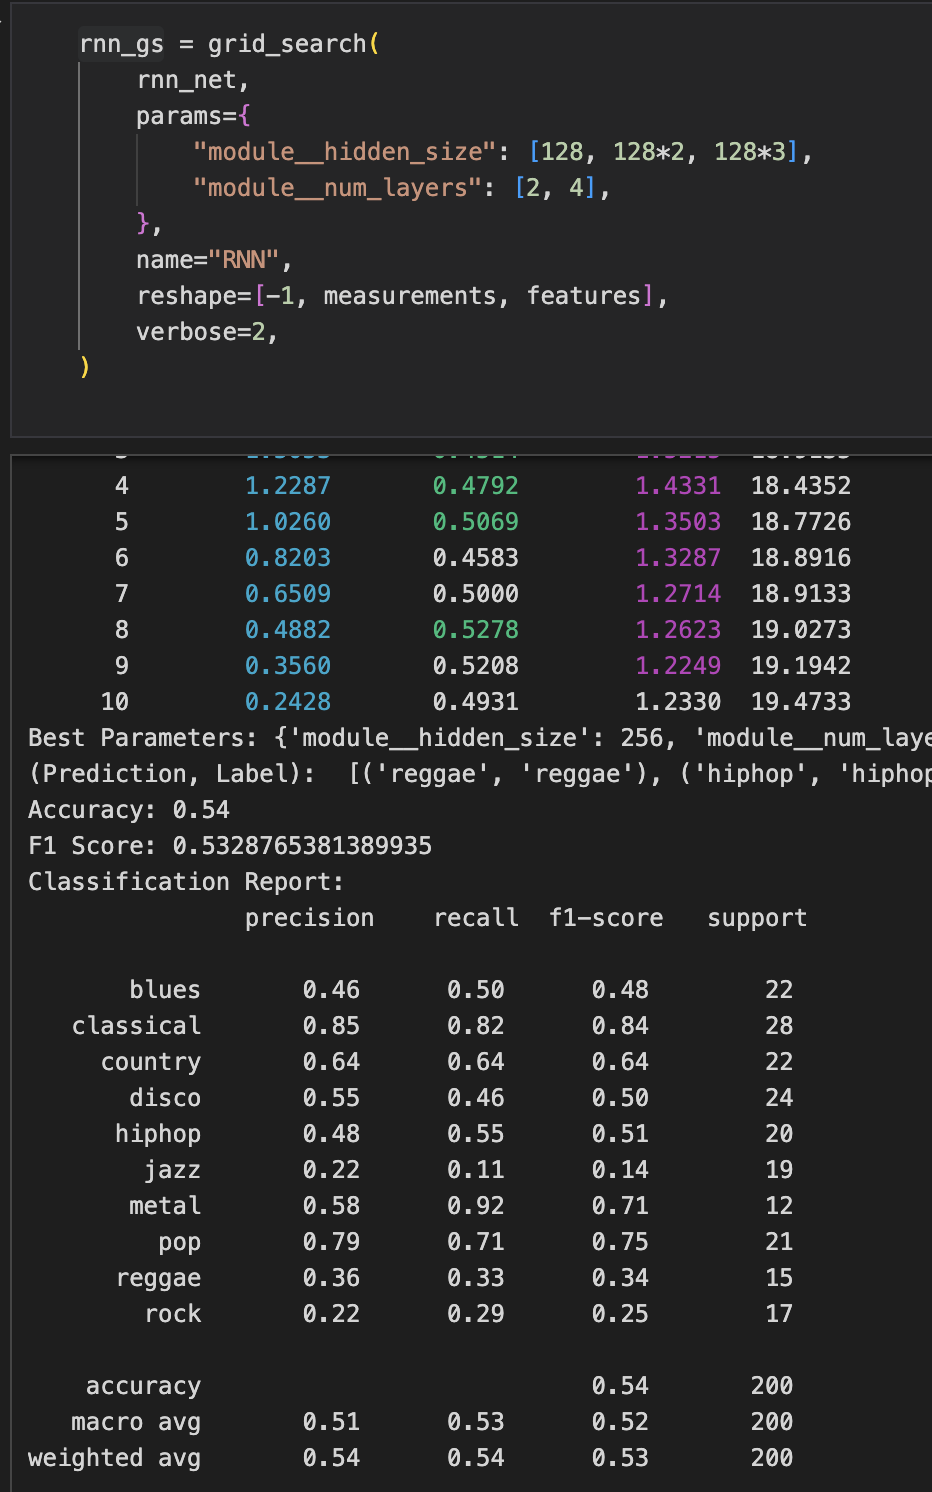
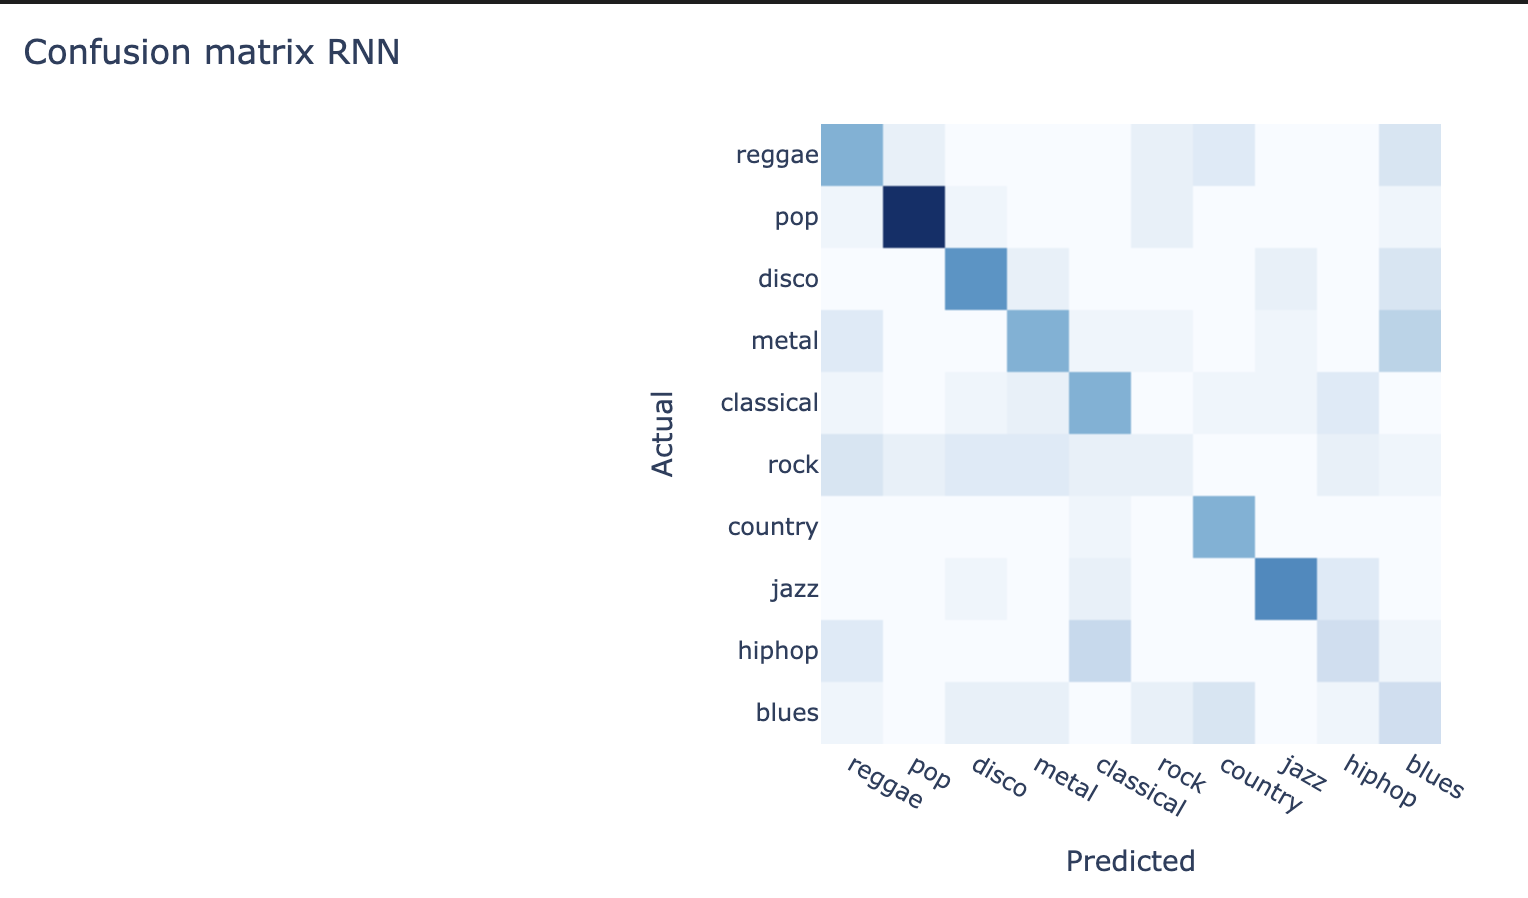

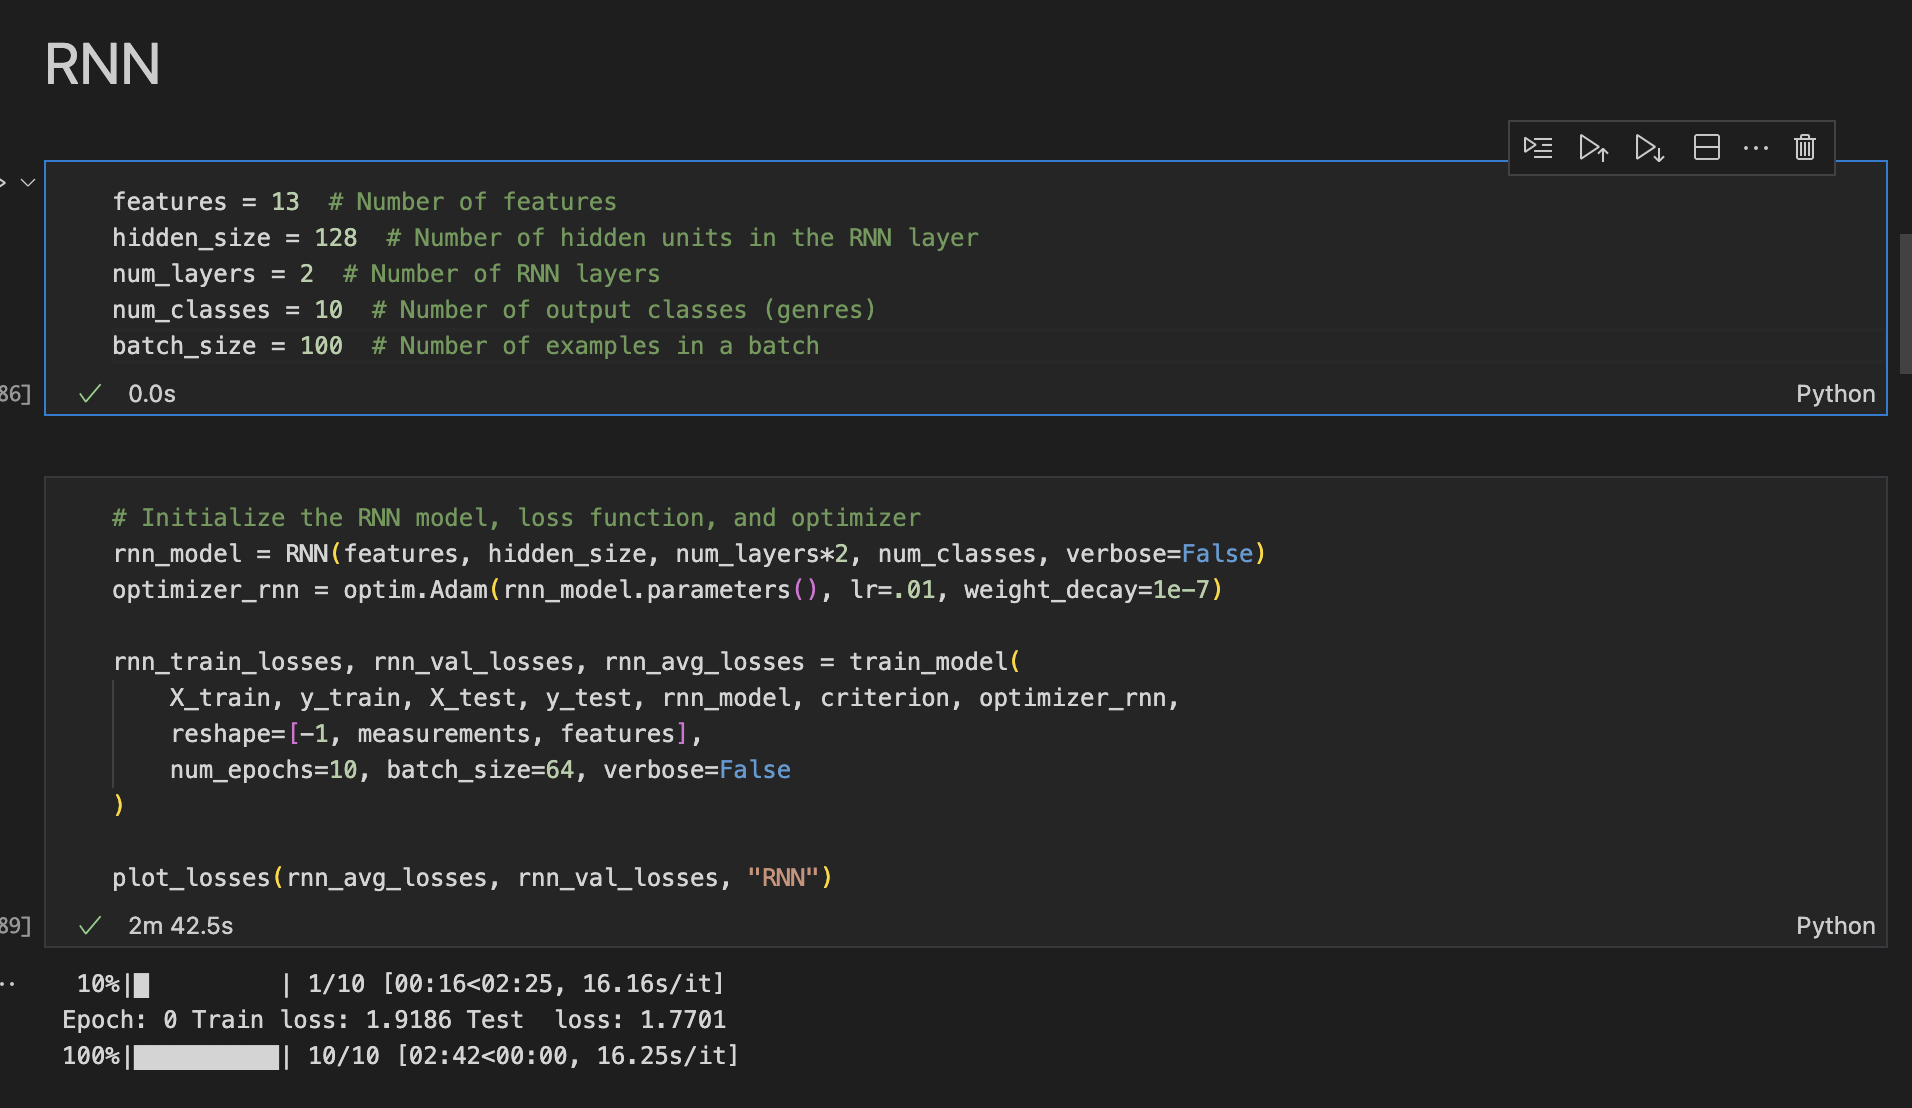

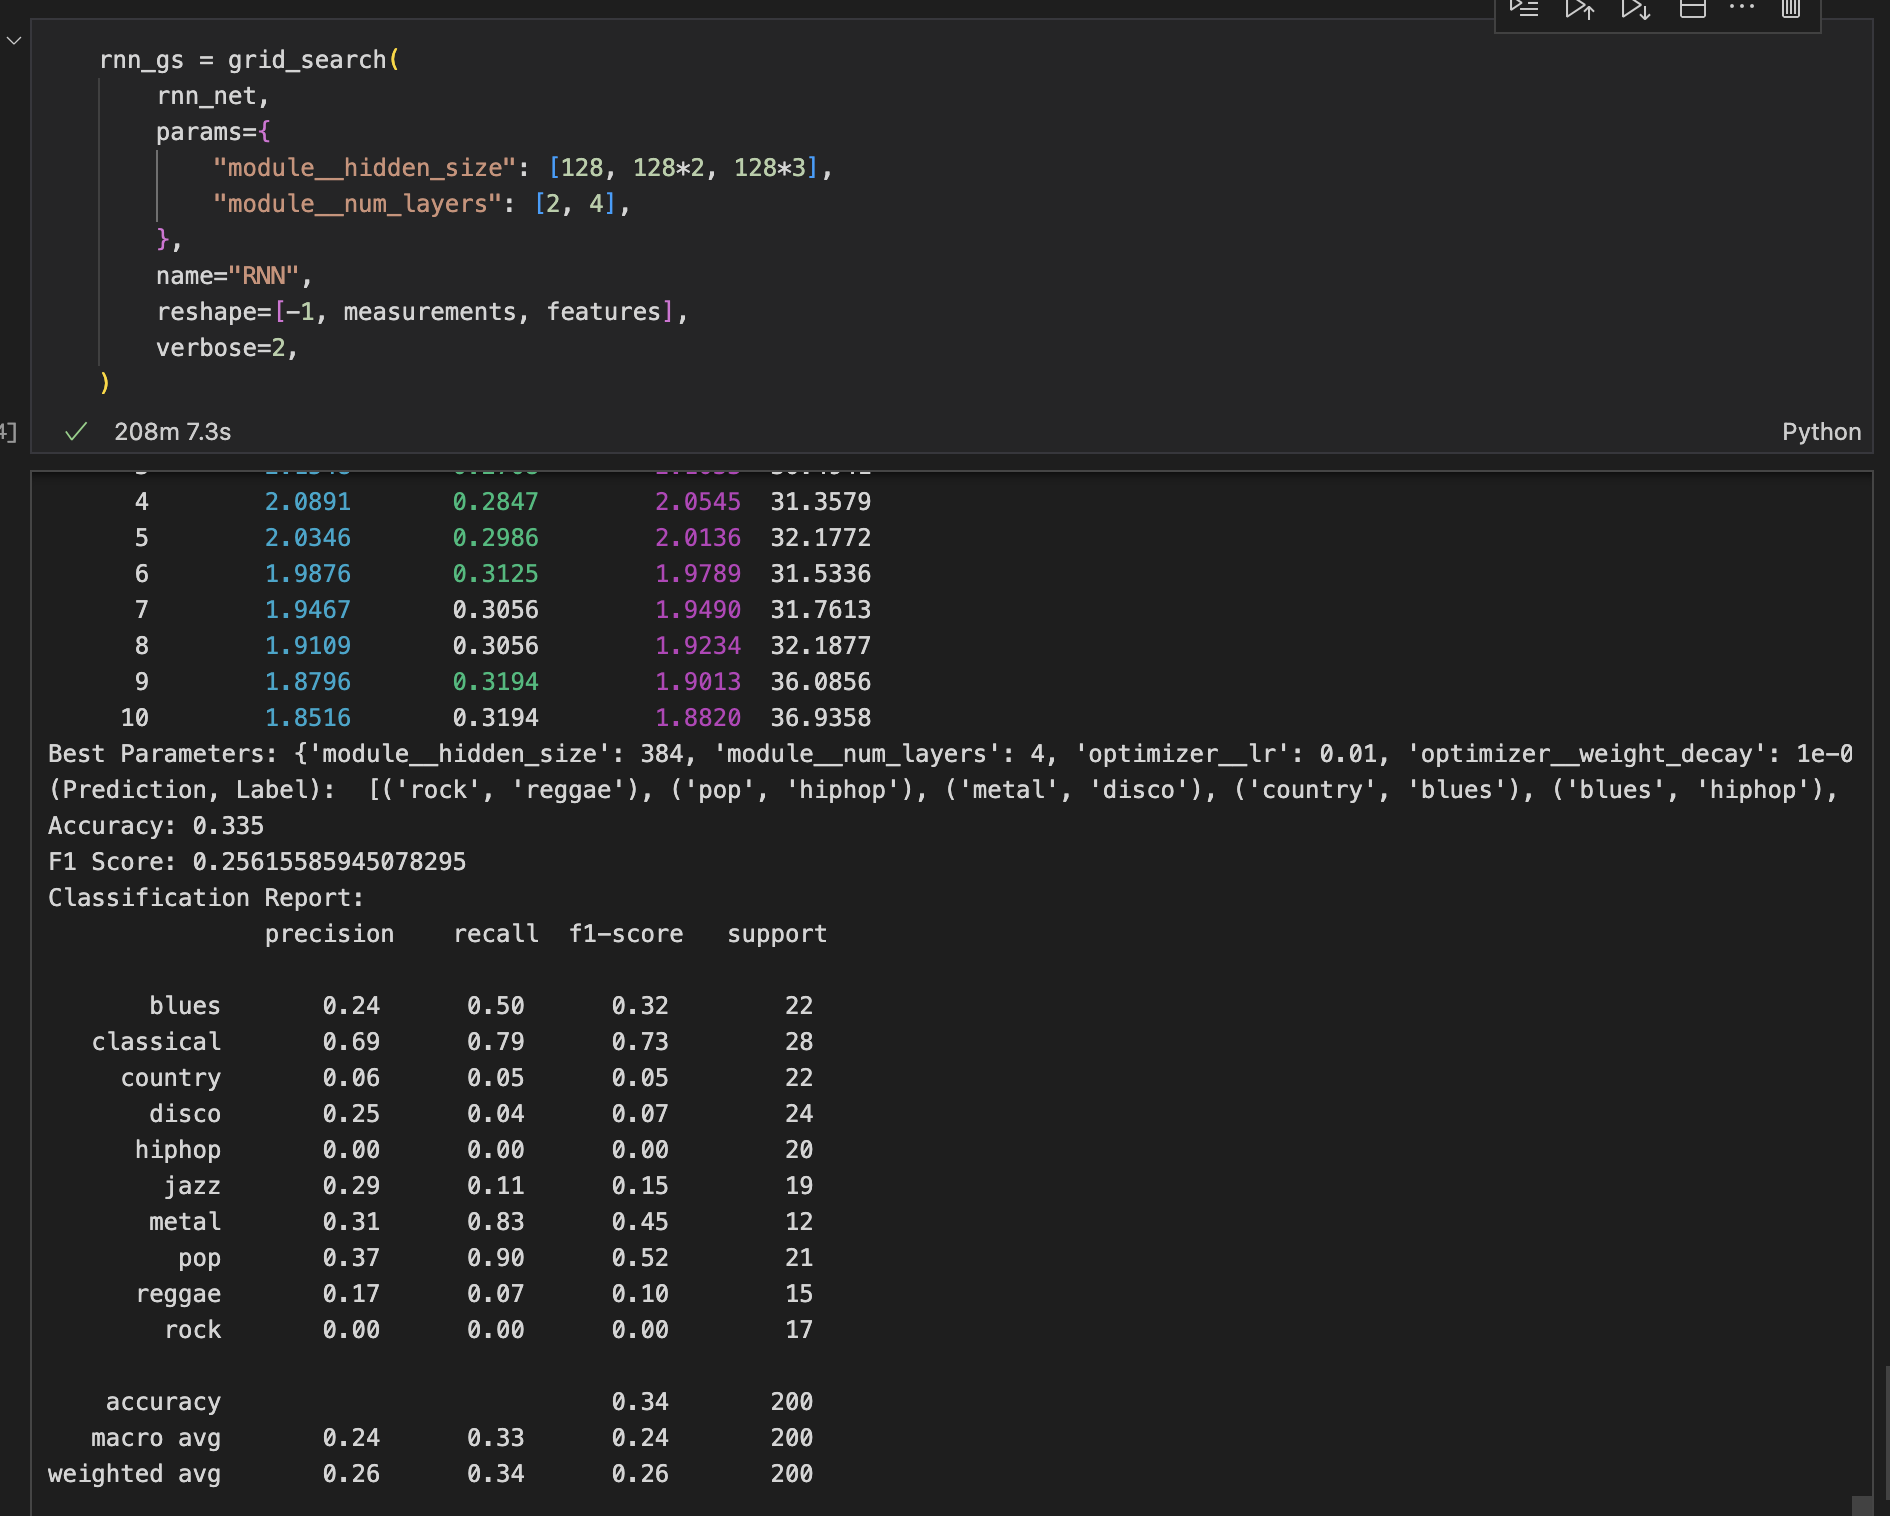

# Analysis

During hyper-parameter tuning, we again were able to bump performance some, but not a lot.
The model that was able to achieve the highest accuracy was the RNN, with an f1-score of 0.58.
Our best traditional classifier was the SVM, with an f1-score of 0.61, meaning that our best neural net was still 3% points behind our best traditional classifier.

One noticable thing is the amount of time training and tuning takes. 
Here, we really seem how the curse of dimensionality limits NNs. 
In addition to being much larger than our tradiational models, the neural nets took much longer to run, and therefore much, much longer to tune. 

These models are very sensitive to hyperparameters, so there are likely even better configurations than the few we tested. 
Although, the small amount of testing we did gives us an indication of how good neural networks are at solving this music genre classification task. 

The confusion matrixes help see which genres are easier to predict than others, using the same code from our previous notebook. 
Across the board, the "classical" genre consistently acheives good results (low misclassifiucation rate), while "rock" is usually among the hardest.


# Conclusion
The results we were able to acheive here were quite poor. 
Our best results were still a few percent points lower than the best results we got from our traditional classifiers.
This is not surprising, as we did minimal hyperparameter tuning, and we did not use any pretrained models.
However, this hints to the fact that high performing neural networks are likely too big and slow for this task.
